# Sample Assessment Geo Data Science

## Abstract

Over the last years, remote sensing has developed satellite sensors to collect high spatial and temporal resolution images from Earth's surface generating large data and new opportunities for developing methods to access and analyse this data, as Earth observation data cubes. With data cubes it is possible to analyse the Earth's surface over temporal and spatial attributes and allows the extraction of Land Use and Land Cover (LULC) features and patterns to map land use changes. This also provides an extensive mass of historical data about phenology and years of image time series [[1]](./README.md#References). Soon, this historical data can be useful for training deep learning algorithms based on temporal and spatial dimensions. The paper [[1]](./README.md#References) demonstrated how this historical data can be used to generate LULC samples using Time-Weighted Dynamic Time Warping (TWDTW). As demonstrated in [[2]](./README.md#References) the current ways to classify land use and land cover maps like Random Forest and Support Vector Machines (SVM) algorithms have been successfully applied to the LULC change classification. However these algorithms do not use the temporal dimension, an important characteristic in data cubes, in the classification process, resulting in lost data. In other words, the order of the images does not influence the results. The approach presented by the paper [[2]](./README.md#References) proposed a comprehensive study of Temporal Convolutional Neural Networks (TempCNNs), an in-depth approach that applies convolutions in the temporal dimension to automatically learn temporal and spectral features. The study presented by [[3]](./README.md#References) demonstrates the good quality of TempCNN to accurately map LULC without over-representation of majority classes using TempCNN. This approach aims to present a study about remote sensing time series features extraction using TempCNN to LULC classification to estimate the probability of LULC class based on deep learning algorithms in order to contribute to LULC sample generation over the Brazilian Biomes territory. This approach will use the Brazil Data Cube infrastructure to collect data and analyse them. To estimate the probability of LULC classes, this study will use an active learning method, a stored model that will predict the class of unlabeled data based on labeled data and stored, as an oracle. This study also seeks to demonstrate a comparison between the temporal based Neural Networks as TempCNN, non-temporal based like CNN and the current methods as the Random Forest and SVM Algorithm.

**Aprendizado por Reforço**

In [3]:
source("./R/utils.R")
citation("sits")


To cite SITS in publications use:

  Rolf Simoes, Gilberto Camara, Felipe Souza, Pedro Andrade, Lorena
  Santos, Karine Ferreira, Gilberto Queiroz, Alexandre Carvalho, Victor
  Maus (2021), SITS: Data Analysis and Machine Learning using Satellite
  Image Time Series. URL https://github.com/e-sensing/sits.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {sits: Data Analysis and Machine Learning using Satellite Image Time Series},
    author = {Rolf Simoes and Gilberto Camara and Felipe Souza and Pedro Andrade and Lorena Santos and Karine Ferreira and Gilberto Queiroz and Alexandre Ywata {de Carvalho} and Victor Maus},
    organization = {INPE - Brazilian National Institute for Space Research},
    address = {Sao Jose dos Campos, Brazil},
    year = {2021},
    url = {https://github.com/e-sensing/sits},
  }


In [13]:
filename <- system.file("extdata/Sentinel-2/samples_amazonia_sentinel2.csv", package = "sitsdata")
samples <- read_file.tb(filename, "csv")
head(samples)

id longitude latitude   start_date end_date   label        
1 1  -64.69448  -9.986312 2018-07-12 2019-07-28 Deforestation
2 2  -64.62979  -9.996668 2018-07-12 2019-07-28 Deforestation
3 3  -64.52163  -9.979772 2018-07-12 2019-07-28 Deforestation
4 4  -64.52049 -10.003682 2018-07-12 2019-07-28 Deforestation
5 5  -64.70766 -10.061506 2018-07-12 2019-07-28 Deforestation
6 6  -64.48304 -10.058156 2018-07-12 2019-07-28 Deforestation

In [14]:
data_ <- dplyr::filter(samples, label != "NatNonForest")
data_n_forest <- dplyr::filter(samples, label == "NatNonForest")
data_n_forest$label <- "NonForest"
samples <- rbind(data_, data_n_forest)
head(samples)

id longitude latitude   start_date end_date   label        
1 1  -64.69448  -9.986312 2018-07-12 2019-07-28 Deforestation
2 2  -64.62979  -9.996668 2018-07-12 2019-07-28 Deforestation
3 3  -64.52163  -9.979772 2018-07-12 2019-07-28 Deforestation
4 4  -64.52049 -10.003682 2018-07-12 2019-07-28 Deforestation
5 5  -64.70766 -10.061506 2018-07-12 2019-07-28 Deforestation
6 6  -64.48304 -10.058156 2018-07-12 2019-07-28 Deforestation

In [15]:
group <- dplyr::group_by(samples, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
colors <- c()
for (i in 1:nrow(agregation)) {
    label <- agregation$label[[i]]
    colors <- append(colors, color.label(label))
}
labels_summary <- dplyr::mutate(
    agregation,
    percent = n/sum(n),
    color = colors
)
labels_summary <- data.frame(labels_summary)
labels_summary <- labels_summary[order(labels_summary$percent, decreasing = TRUE),]
labels_summary

label         n   percent   color  
4 Pasture       460 0.3826955 #ff8828
2 Forest        414 0.3444260 #005500
3 NonForest     171 0.1422629 #0fc80f
1 Deforestation 157 0.1306156 #ff5f4c

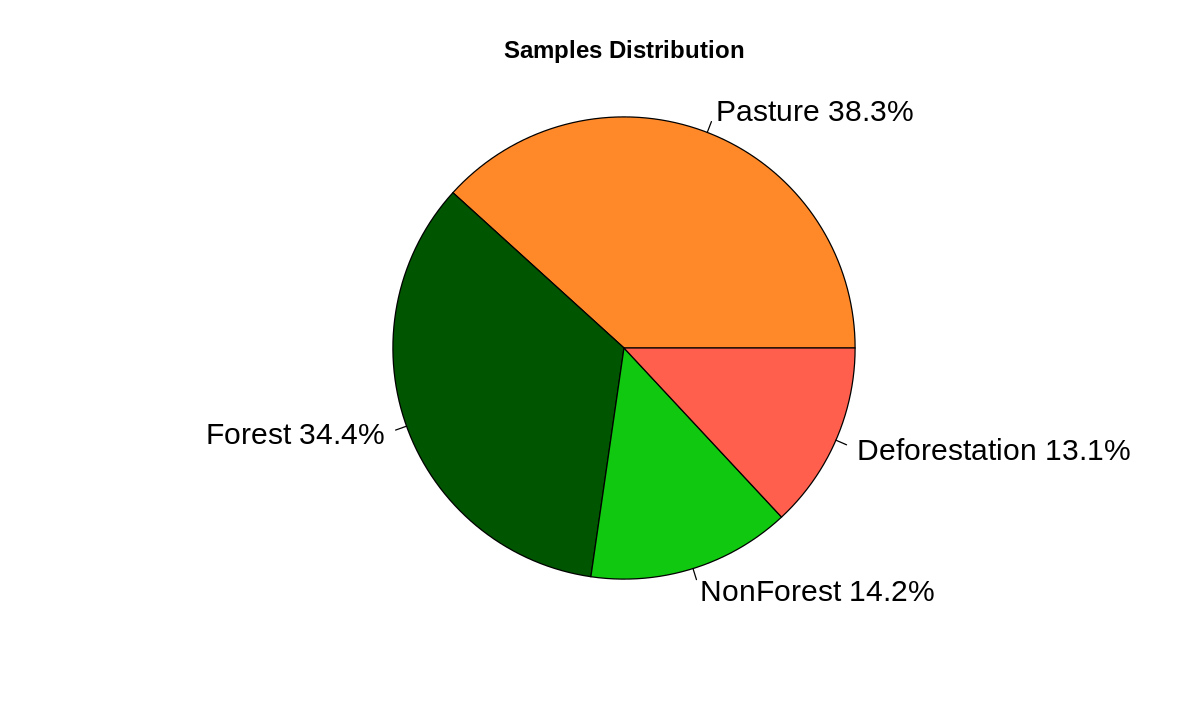

In [16]:
options(repr.plot.width = 10, repr.plot.height = 6)
pie(
    labels_summary$percent,
    paste(labels_summary$label, " ", round(labels_summary$percent * 100, 1), "%", sep=""),
    col = labels_summary$color,
    main = "Samples Distribution",
    cex = 1.5,
    radius = 1
)

In [17]:
longitude = samples$longitude
latitude = samples$latitude
latlng = cbind(longitude, latitude)
points <- SpatialPoints(latlng)
bbox <- bbox(points)
bbox

min       max      
longitude -65.27259 -63.69919
latitude  -10.96711  -9.95304

In [18]:
roi <-  c(
    lon_min = as_tibble(bbox)$min[[1]],
    lon_max = as_tibble(bbox)$max[[1]],
    lat_min = as_tibble(bbox)$min[[2]],
    lat_max = as_tibble(bbox)$max[[2]]
)
roi

lon_min   lon_max   lat_min   lat_max 
-65.27259 -63.69919 -10.96711  -9.95304

In [19]:
bbox_shape <- list(
    longitude = c(roi[["lon_min"]], roi[["lon_max"]]),
    latitude = c(roi[["lat_min"]], roi[["lat_max"]])
)
bbox_shape <- as.data.frame(bbox_shape)
bbox_shape

longitude latitude 
1 -65.27259 -10.96711
2 -63.69919  -9.95304

In [23]:
date <- "2019-01-01"
label <- "Pasture"

shape <- point_to_shape_sp(
    data.tb = samples,
    date = date,
    class_label = label
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
    addProviderTiles('Esri.WorldImagery') %>%
        addRectangles(
            lng1 = bbox_shape$longitude[[1]], bbox_shape$latitude[[1]],
            lng2 = bbox_shape$longitude[[2]], bbox_shape$latitude[[2]],
            fillColor = "transparent",
            popup = "Bounding Box") %>%
            addCircleMarkers(
                ~longitude, ~latitude,
                fillOpacity = 1,
                fillColor = color.label(label),
                stroke = F,
                radius = 5,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                          format(
                              as.Date(start_date),
                              format = "Start %Y-%m-%d"
                          ),
                          format(
                              as.Date(end_date),
                              format = "End %Y-%m-%d"
                          )
                )))

Error : Can't subset columns that don't exist.
✖ Column `cube` doesn't exist.
Error : Can't subset columns that don't exist.
✖ Column `cube` doesn't exist.


HTML widgets cannot be represented in plain text (need html)

In [24]:
sits_list_collections(source = "BDC")

BDC:
- CB4_64-1 (CBERS-4/AWFI)
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CB4_64_16D_STK-1 (CBERS-4/AWFI)
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CB4MUX_20-1 (CBERS-4/MUX)
- bands: NDVI EVI B5 B6 B7 B8 CLOUD
- opendata collection (requires access token)

- CB4_20_1M_STK-1 (CBERS-4/MUX)
- bands: NDVI EVI B5 B6 B7 B8 CLOUD
- opendata collection (requires access token)

- LC8_30-1 (LANDSAT-8/OLI)
- bands: NDVI EVI B1 B2 B3 B4 B5 B6 B7 CLOUD
- opendata collection (requires access token)

- LC8_30_16D_STK-1 (LANDSAT-8/OLI)
- bands: NDVI EVI B1 B2 B3 B4 B5 B6 B7 CLOUD
- opendata collection (requires access token)

- MOD13Q1-6 (TERRA/MODIS)
- bands: NDVI EVI BLUE RED NIR MIR CLOUD
- opendata collection (requires access token)

- MYD13Q1-6 (AQUA/MODIS)
- bands: NDVI EVI BLUE RED NIR MIR CLOUD
- opendata collection (requires access token)

- S2-SEN2COR_10_16D_STK-1 (SENTINEL-2/MSI)
- bands: NDVI EVI B

[1] "2018-07-12" "2018-07-28" "2018-08-13" "2018-08-29" "2018-09-14"
 [6] "2018-09-30" "2018-10-16" "2018-11-01" "2018-11-17" "2018-12-03"
[11] "2018-12-19" "2019-01-01" "2019-01-17" "2019-02-02" "2019-02-18"
[16] "2019-03-06" "2019-03-22" "2019-04-07" "2019-04-23" "2019-05-09"
[21] "2019-05-25" "2019-06-10" "2019-06-26" "2019-07-12" "2019-07-28"

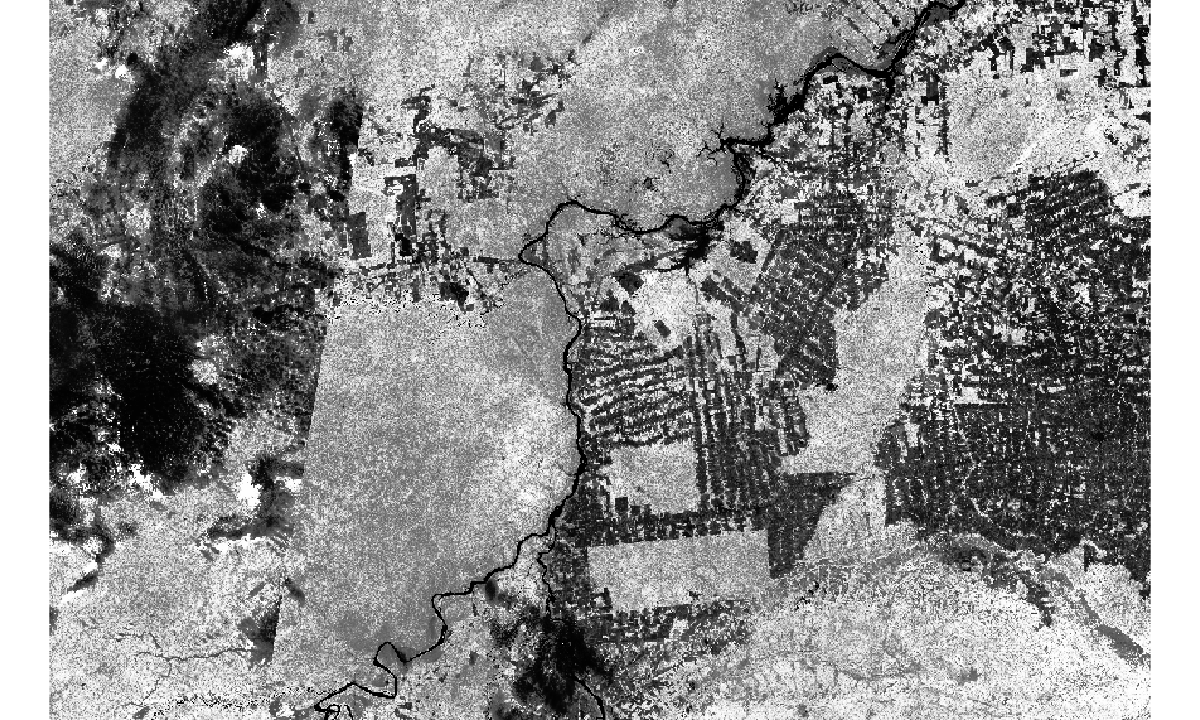

In [27]:
Sys.setenv("BDC_ACCESS_KEY" = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV")
landsat_cube <- sits_cube(
    source = "BDC",
    collection = "LC8_30_16D_STK-1",
    bands = c("B4", "B3", "B2", "B7", "EVI", "NDVI", "CLOUD"),
    start_date = "2018-07-12",
    end_date = "2019-07-28",
    roi = roi
)
sits_timeline(landsat_cube)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(landsat_cube, band = "NDVI", time = 1)

In [33]:
# points <- sits_get_data(landsat_cube, file = filename)
points <- read_file.tb("./data/samples/samples_amazonia_landsat8.rda", "rda")
save_file.tb(points, "./data/samples/samples_amazonia_landsat8", "rda")

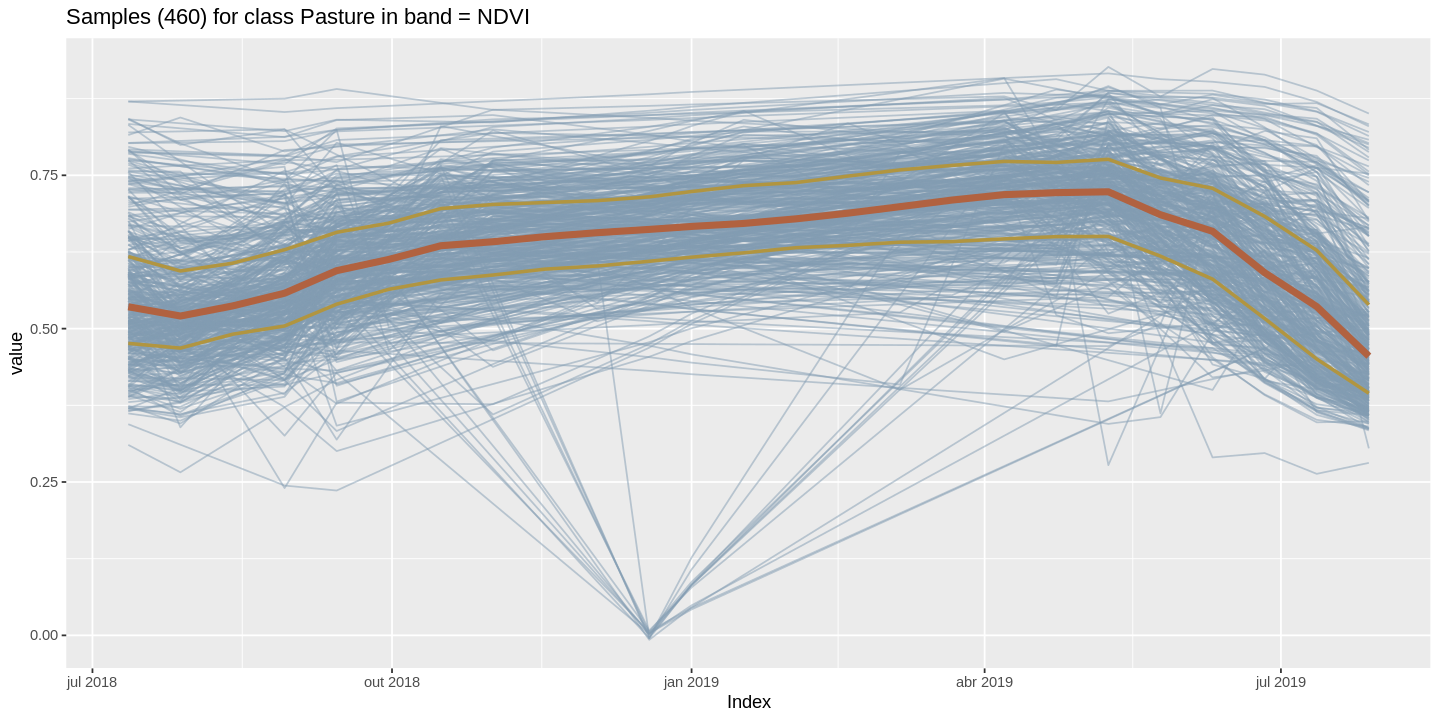

In [34]:
options(repr.plot.width = 12, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Pasture")
plot(sits_select(filtered, bands = "NDVI"))

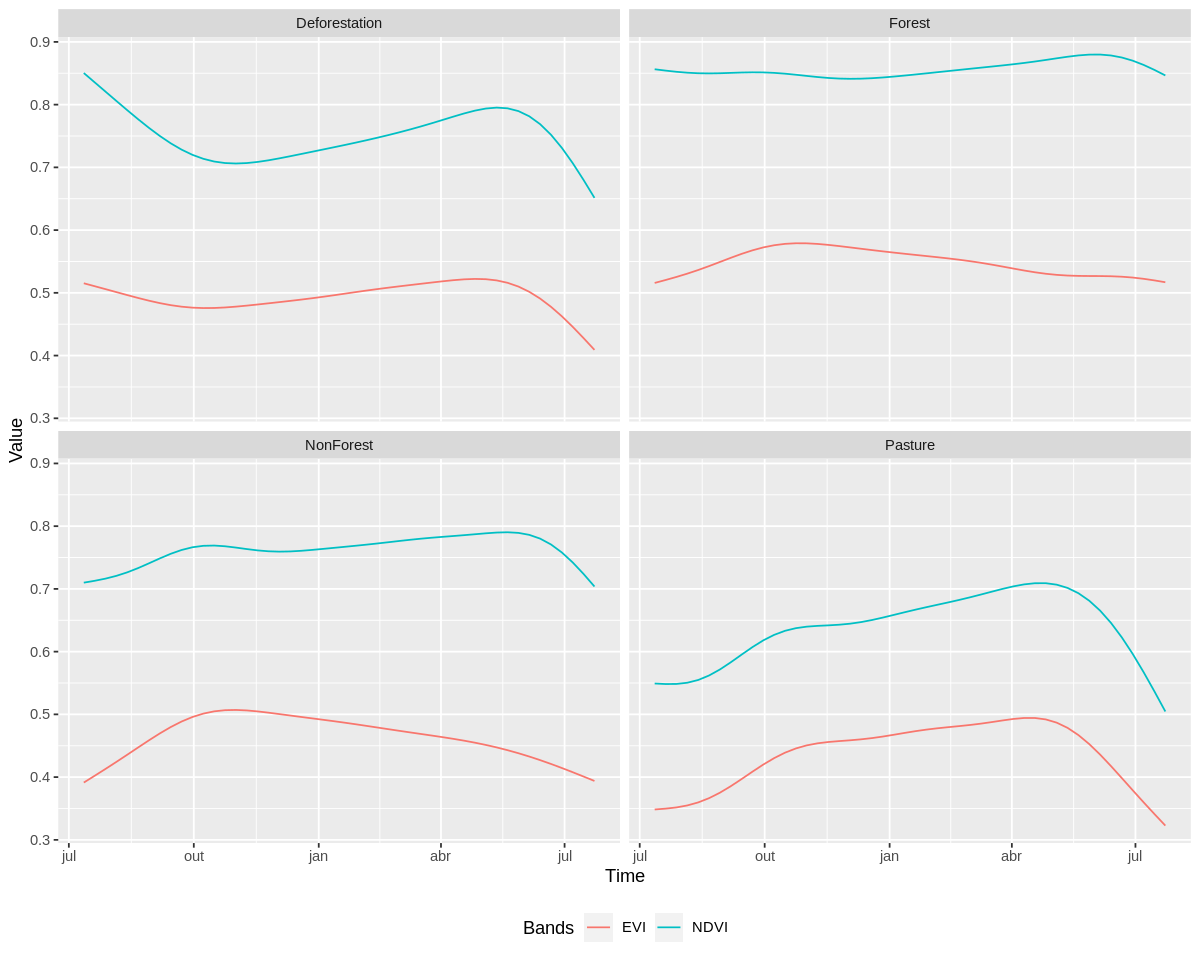

In [35]:
options(repr.plot.width = 10, repr.plot.height = 8)
plot(sits_patterns(sits_select(points, bands = c("NDVI", "EVI"))))

In [36]:
size_grid <- as.integer(sqrt(5 * sqrt(length(points$label))))
size_grid

[1] 13

In [37]:
set.seed(775)
clustering.lst <- sits::sits_som_map(
    points,
    grid_xdim = size_grid,
    grid_ydim = size_grid,
    alpha = c(0.5, 0.01),
    distance = "euclidean",
    rlen = 100,
    som_radius = 1
)
clustering.lst

$data
# A tibble: 1,202 × 9
   longitude latitude start_date end_date   label  cube    time_series id_sample
       <dbl>    <dbl> <date>     <date>     <chr>  <chr>   <list>          <int>
 1     -64.7    -9.99 2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         1
 2     -64.6   -10.0  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         2
 3     -64.5    -9.98 2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         3
 4     -64.5   -10.0  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         4
 5     -64.7   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         5
 6     -64.5   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         6
 7     -64.7   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         7
 8     -64.7   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         8
 9     -64.7   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…         9
10     -64.5   -10.1  2018-07-12 2019-07-28 Defor… LC8_30… <tibble [2…        10


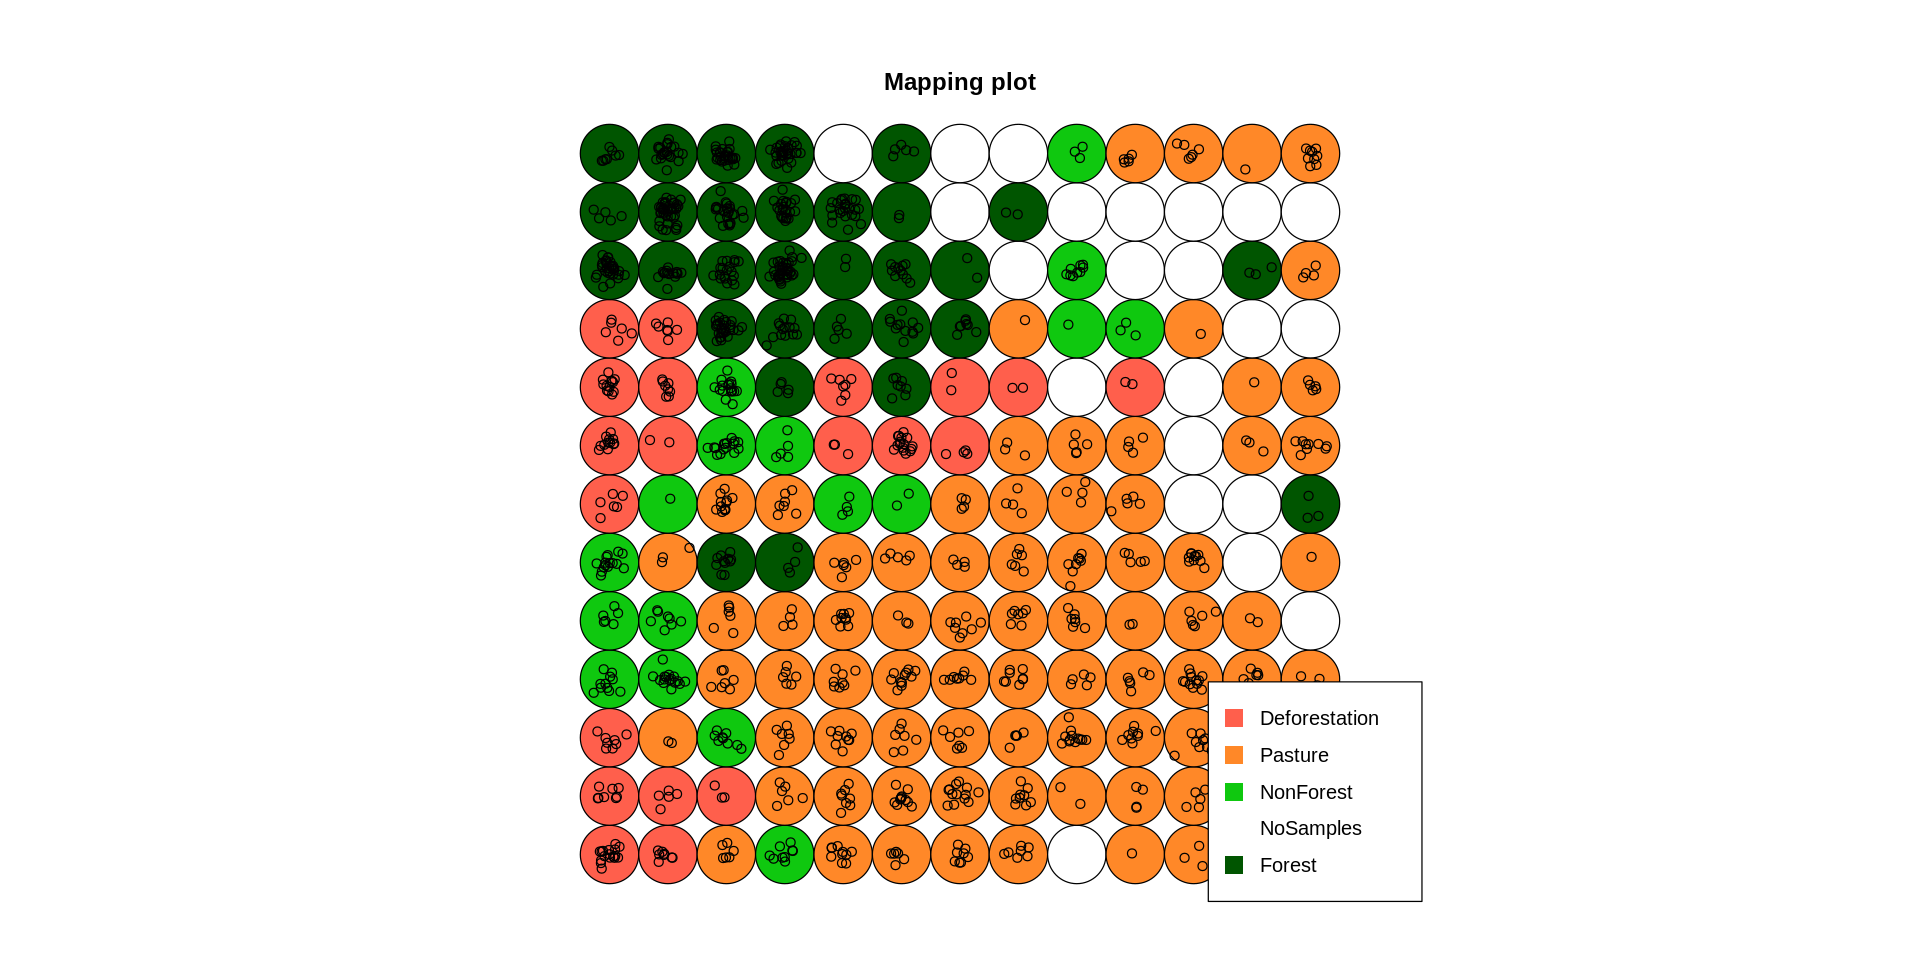

In [38]:
options(repr.plot.width = 16, repr.plot.height = 8)
clustering.lst <- to.color(clustering.lst)
plot(clustering.lst, type = "mapping")

Joining, by = "id_neuron"



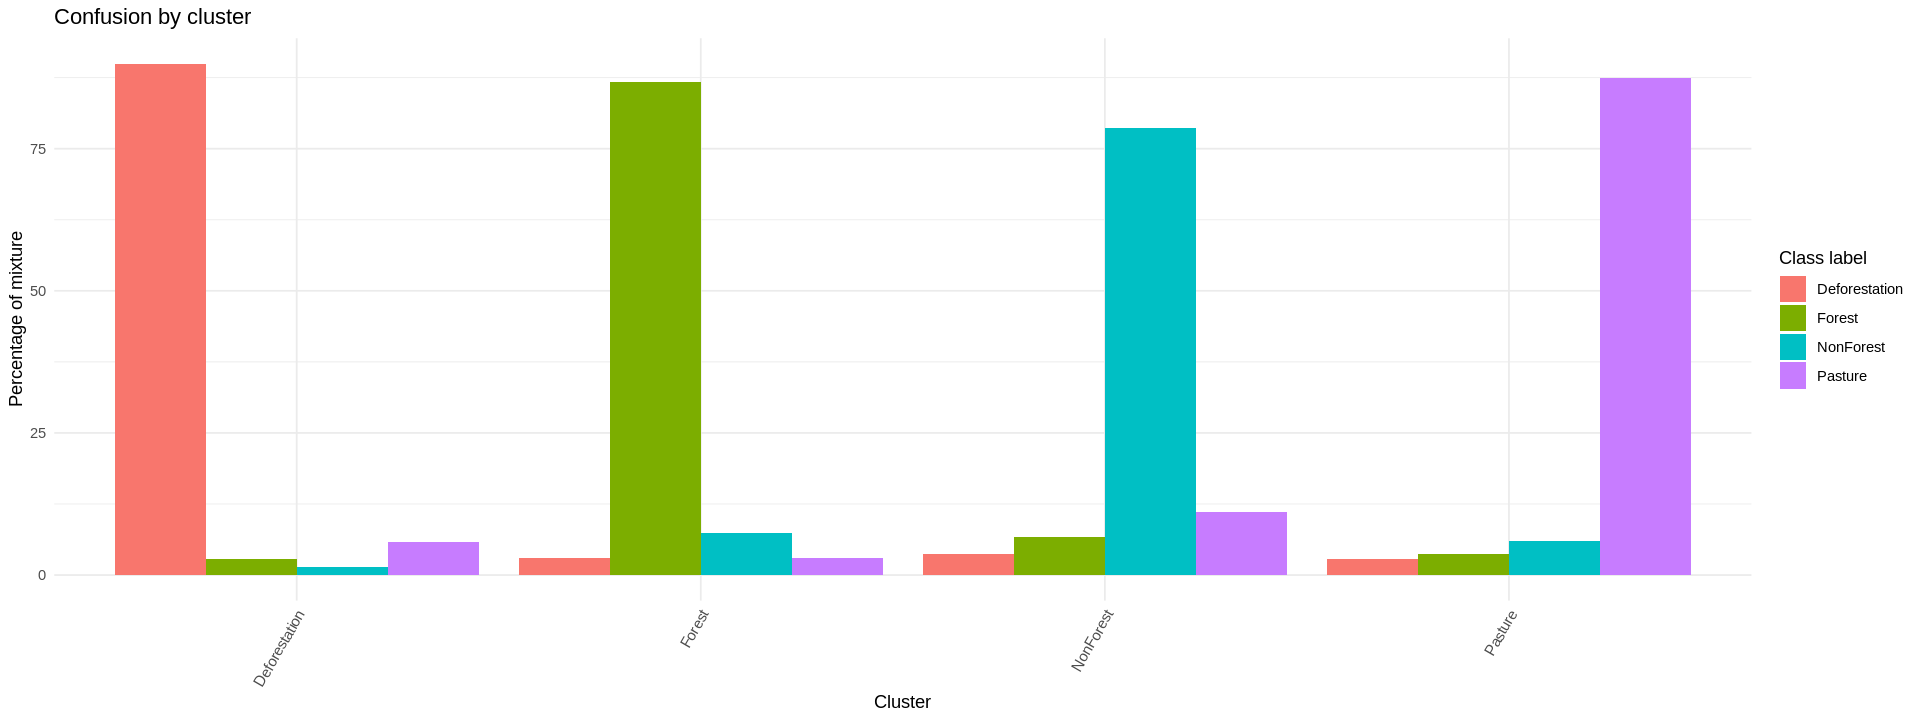

In [39]:
cluster_mixture <- sits_som_evaluate_cluster(clustering.lst)
options(repr.plot.width = 16, repr.plot.height = 6)
plot(cluster_mixture)

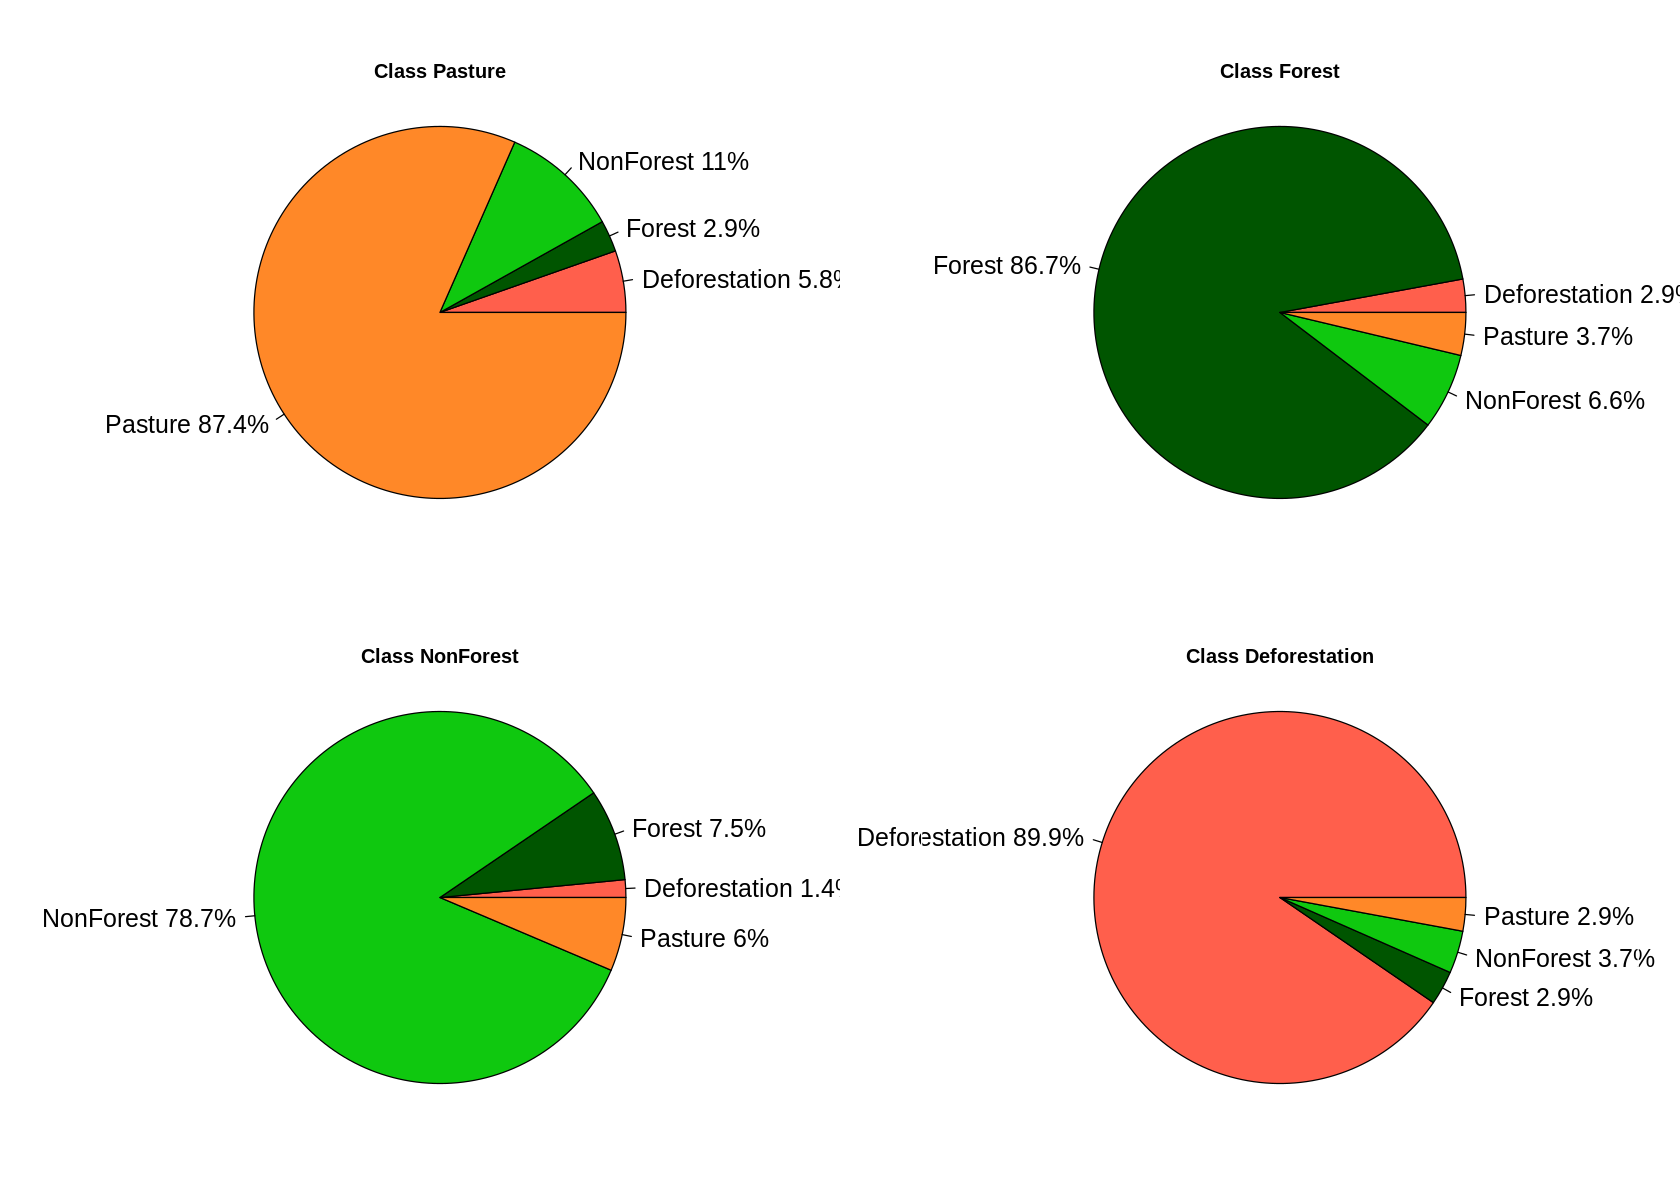

In [41]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1.5,0), tck = 0)
for (i in 1:nrow(labels_summary)) {
    filtered <- dplyr::filter(cluster_mixture, class == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$cluster)) {
        colors <- append(colors, color.label(filtered$cluster[[i]]))
    }
    mutation_ <- dplyr::mutate(filtered, color = colors)
    pie(
        mutation_$mixture_percentage,
        paste(mutation_$cluster, " ", round(mutation_$mixture_percentage, 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$class[[1]]),
        cex = 1.5,
        radius = 1
    )
}
box(col = "white")

In [42]:
samples_quality <- sits_som_clean_samples(
    clustering.lst,
    prior_threshold = 0.4,
    posterior_threshold = 0.3,
    keep = c("clean", "analyze","remove")
)
samples_status <- dplyr::select(samples_quality, -time_series)
head(samples_status, 3)

longitude latitude  start_date end_date   label         cube            
1 -64.69448 -9.986312 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
2 -64.62979 -9.996668 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
3 -64.52163 -9.979772 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
  id_sample id_neuron post_prob eval 
1 1          1        0.8733115 clean
2 2         15        0.6002052 clean
3 3         97        0.9999997 clean

In [44]:
group <- dplyr::group_by(samples_status, label, eval)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
agregation

label         eval    n  
1  Deforestation analyze   3
2  Deforestation clean   123
3  Deforestation remove   31
4  Forest        analyze  11
5  Forest        clean   373
6  Forest        remove   30
7  NonForest     analyze  20
8  NonForest     clean    94
9  NonForest     remove   57
10 Pasture       analyze  15
11 Pasture       clean   412
12 Pasture       remove   33

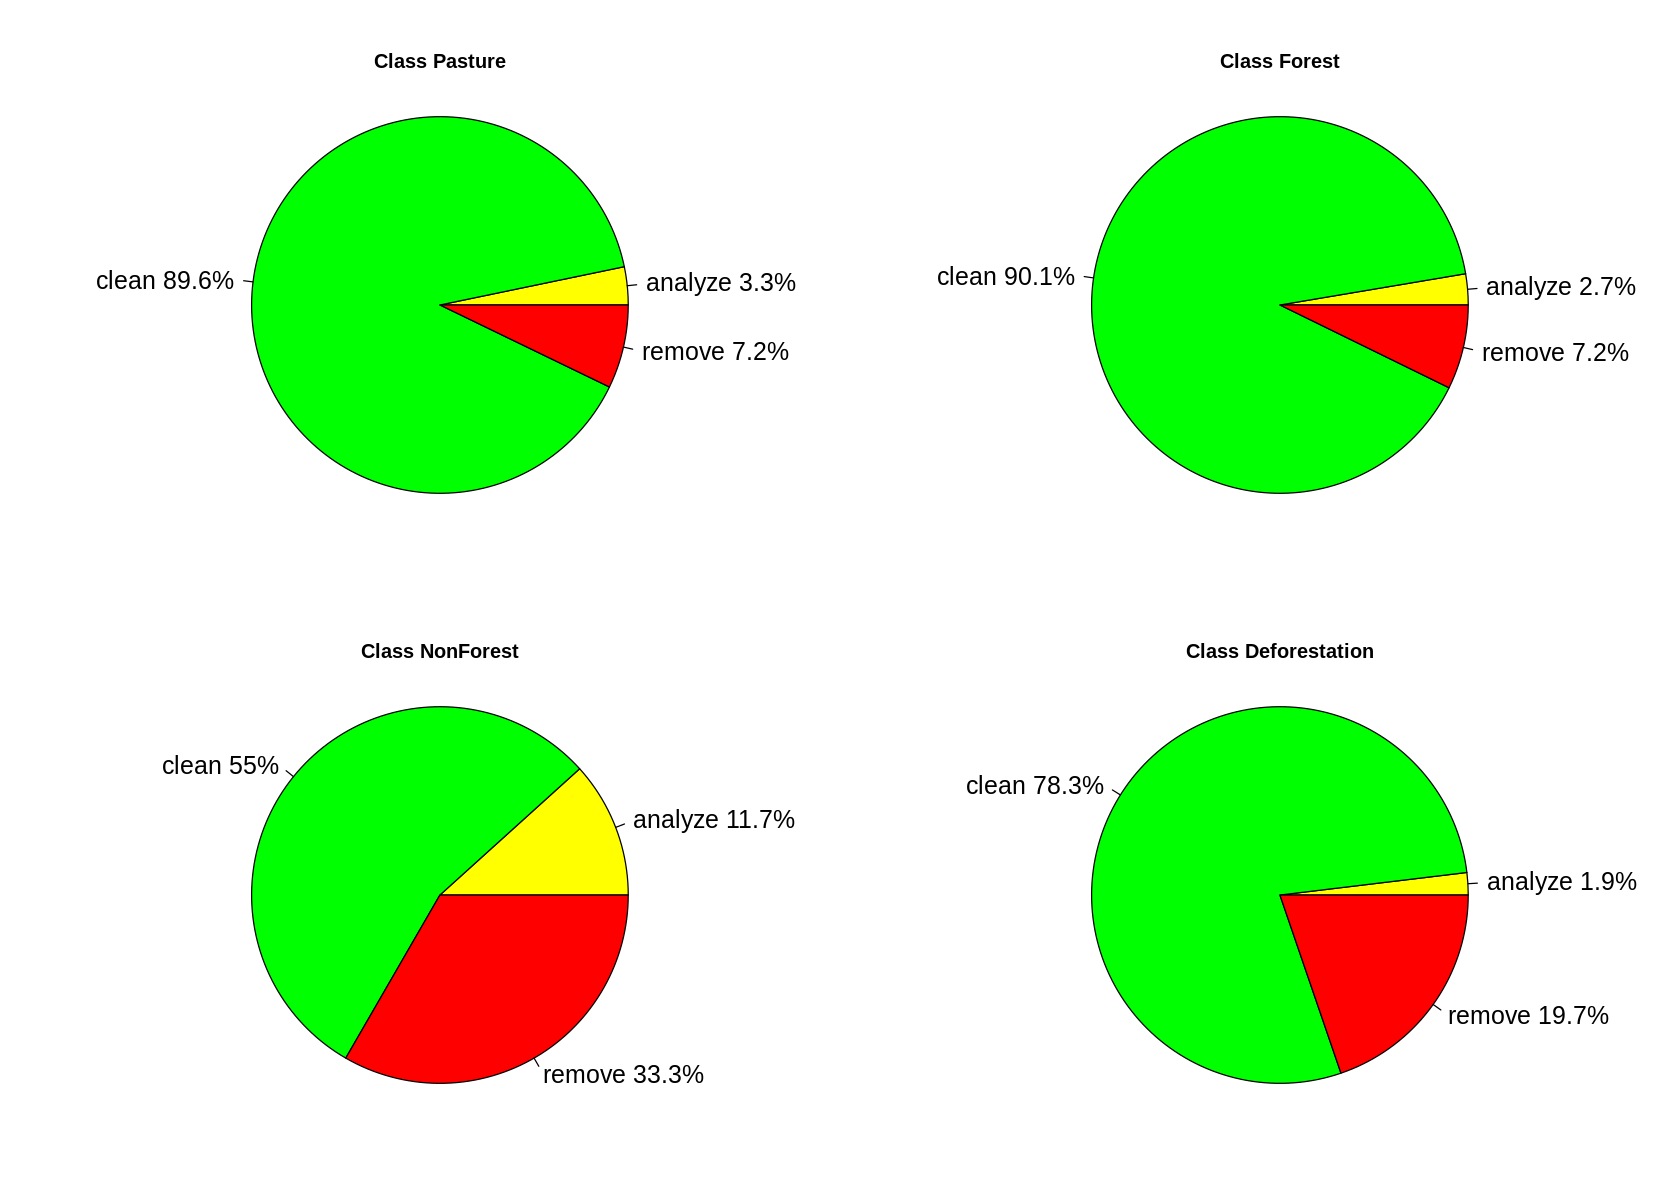

In [46]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1,0), tck = 0)
for (i in 1:nrow(labels_summary)) {
    filtered <- dplyr::filter(agregation, label == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$eval)) {
        colors <- append(colors, color.label(filtered$eval[[i]]))
    }
    mutation_ <- dplyr::mutate(filtered, percent = n/sum(n), color = colors)
    pie(
        mutation_$percent,
        paste(mutation_$eval, " ", round(mutation_$percent * 100, 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$label[[1]]),
        cex = 1.5,
        radius = 1
    )
}
box(col = "white")

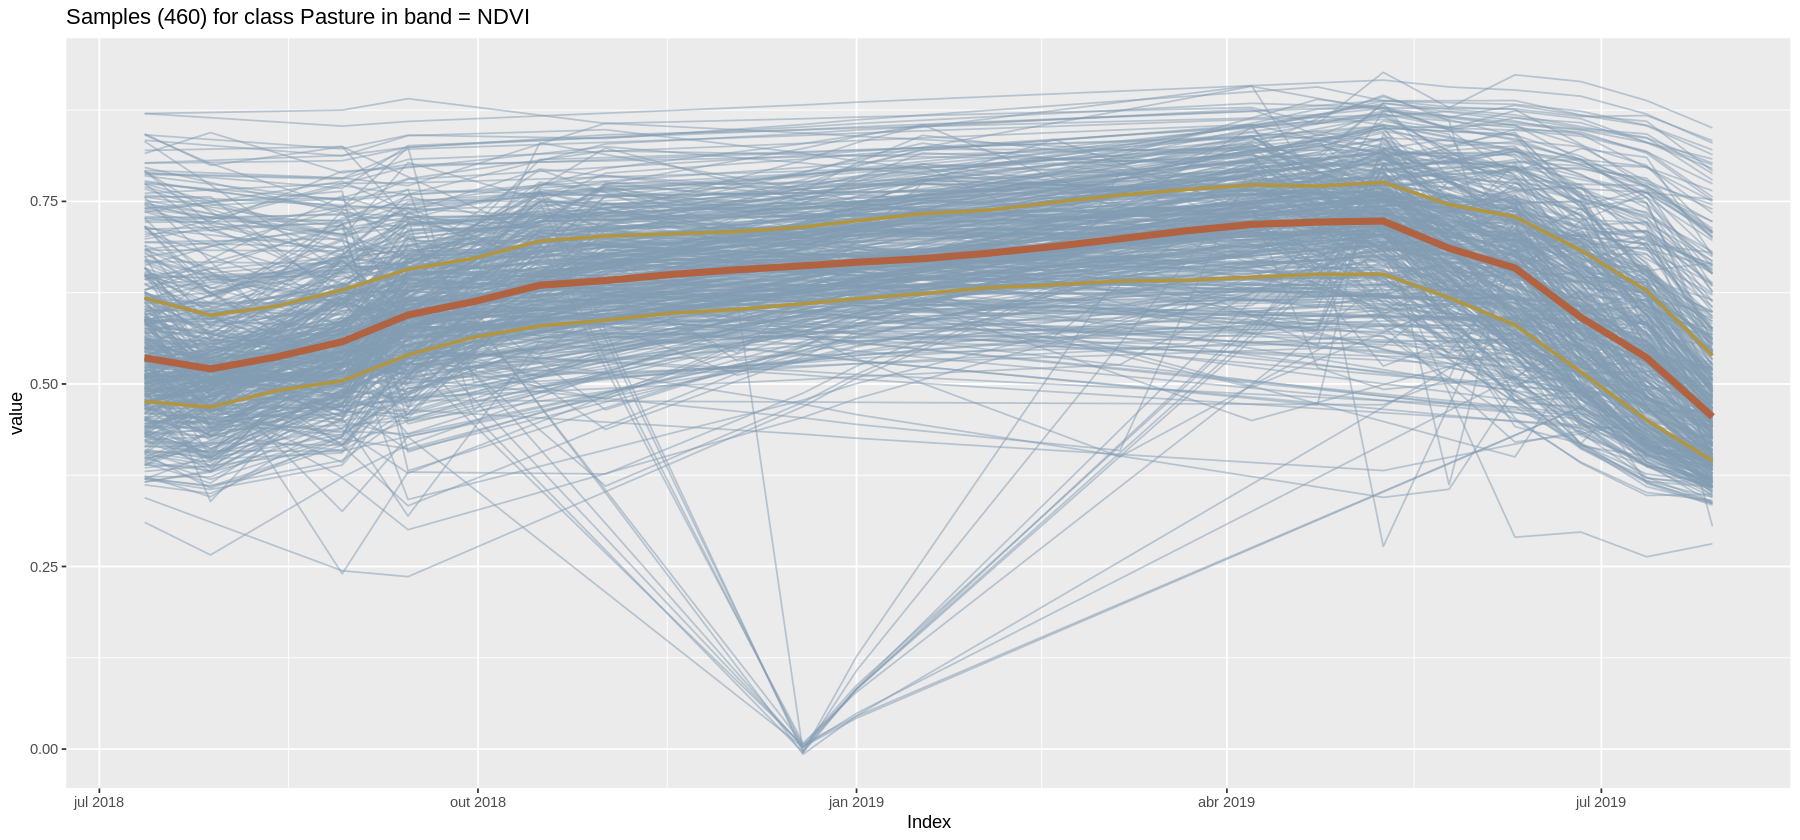

In [49]:
pasture <- dplyr::filter(points, label == "Pasture")
options(repr.plot.width = 15, repr.plot.height = 7)
plot(sits_select(pasture, bands = "NDVI"))

In [54]:
samples_filtered <- sits_whittaker(
    points,
    lambda = 0.4,
    bands_suffix = ""
)
rows <- sample(nrow(samples_filtered), replace = FALSE)
samples_filtered <- samples_filtered[rows, ]
dt <- sample(nrow(samples_filtered), nrow(samples_filtered) * 0.7, replace = FALSE)
train <- samples_filtered[dt,]
test <- samples_filtered[-dt,]
sample <- test[sample(nrow(test), 1), ]
label_ <- sample$label
sample$label <- "Unknown"

print(paste("Trainig data set =", nrow(train), "samples"))
print(paste("Testing data set =", nrow(test), "samples"))
print(paste("Sample to test =", 1, "samples"))

[1] "Trainig data set = 841 samples"
[1] "Testing data set = 361 samples"
[1] "Sample to test = 1 samples"


In [55]:
train_ <- as.data.frame(list())
for (label_ in labels_summary$label) {
    for (i in 1:2) {
        train_ <- rbind(train_, dplyr::filter(train, label == label_)[i, ])
    }
}
test_ <- as.data.frame(list())
for (label_ in labels_summary$label) {
    for (i in 1:2) {
        test_ <- rbind(train_, dplyr::filter(test, label == label_)[i, ])
    }
}

In [56]:
arch <- sits_TempCNN(
    cnn_layers = c(16, 64, 64),
    cnn_kernels = c(8, 8, 8),
    cnn_activation = 'relu',
    cnn_L2_rate = 1e-06,
    cnn_dropout_rates = c(0.4, 0.6, 0.8),
    epochs = 30,
    batch_size = 64,
    validation_split = 0.2,
    verbose = 2,
    optimizer = keras::optimizer_adam()
)

In [57]:
# train a machine learning model using tempCNN
# Modificar os parâmetros da rede para a ResNET
# tCNN_model <- sits_train(train, arch)
tCNN_model <- sits_train(train_, arch)

`geom_smooth()` using formula 'y ~ x'



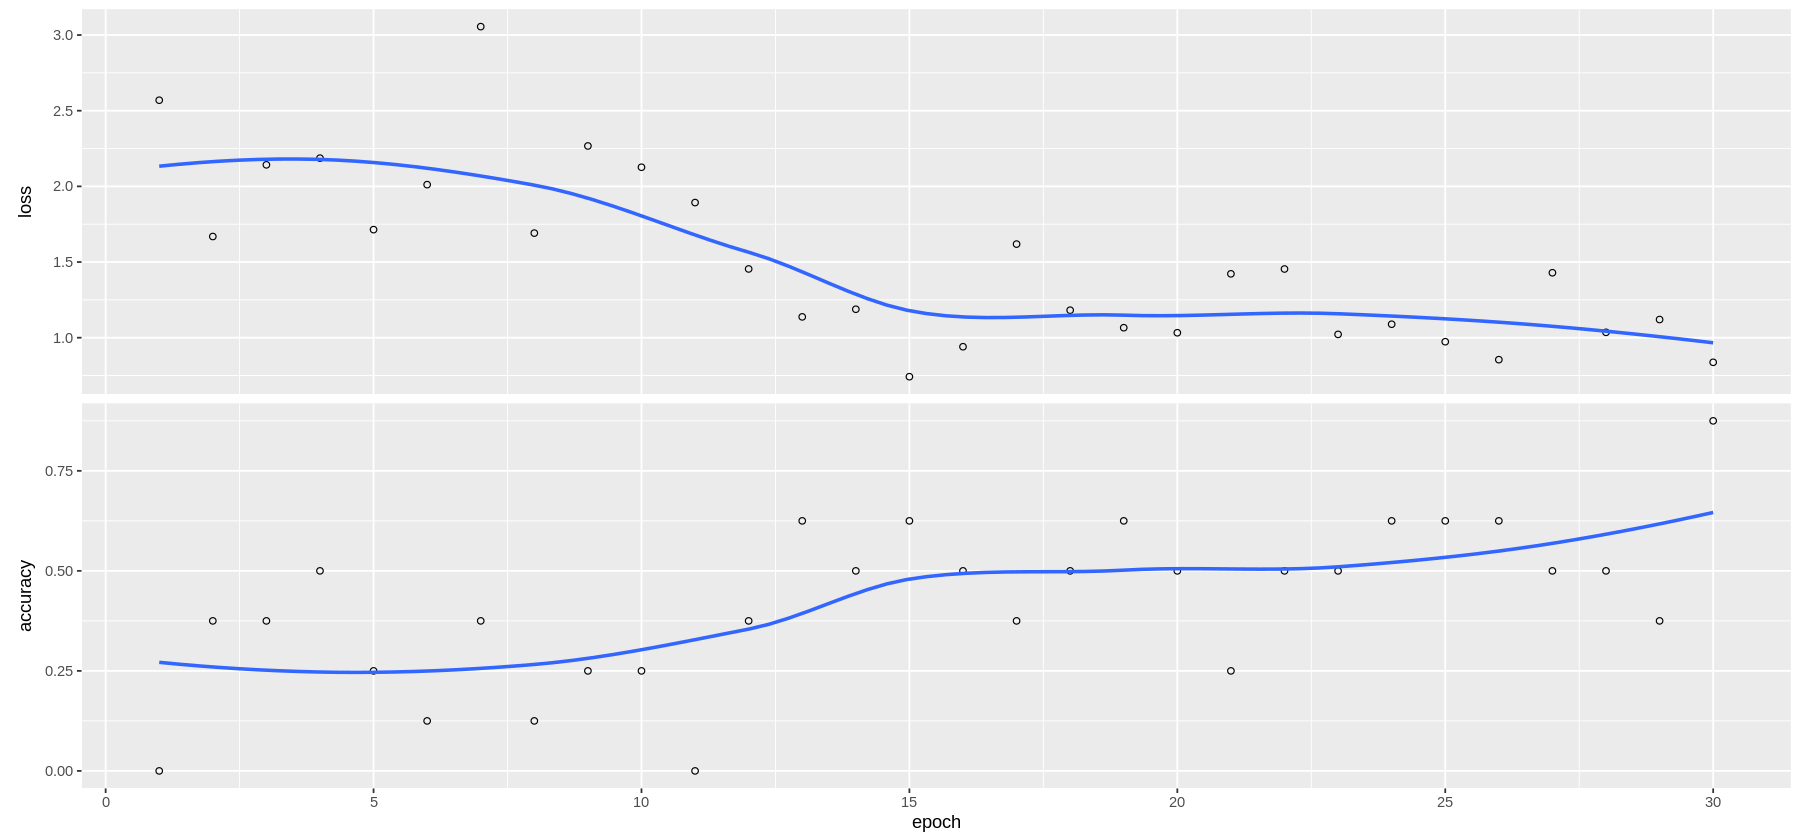

In [58]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot(tCNN_model)

In [59]:
# Classify using TempCNN model and plot the result
class <- test %>% sits_classify(tCNN_model)
results <- sits_accuracy(class)
results

Confusion Matrix and Statistics

               Reference
Prediction      Forest Pasture Deforestation NonForest
  Forest           121      21            31        34
  Pasture            0      20             1         2
  Deforestation      5      66            17         6
  NonForest          0      30             3         4

Overall Statistics
                            
 Accuracy : 0.4488          
   95% CI : (0.3967, 0.5017)
                            
    Kappa : 0.2398          

Statistics by Class:

                          Class: Forest Class: Pasture Class: Deforestation
Prod Acc (Sensitivity)           0.9603         0.1460               0.3269
Specificity                      0.6340         0.9866               0.7508
User Acc (Pos Pred Value)        0.5845         0.8696               0.1809
Neg Pred Value                   0.9675         0.6538               0.8689
                          Class: NonForest
Prod Acc (Sensitivity)             0.08696
Specificity  

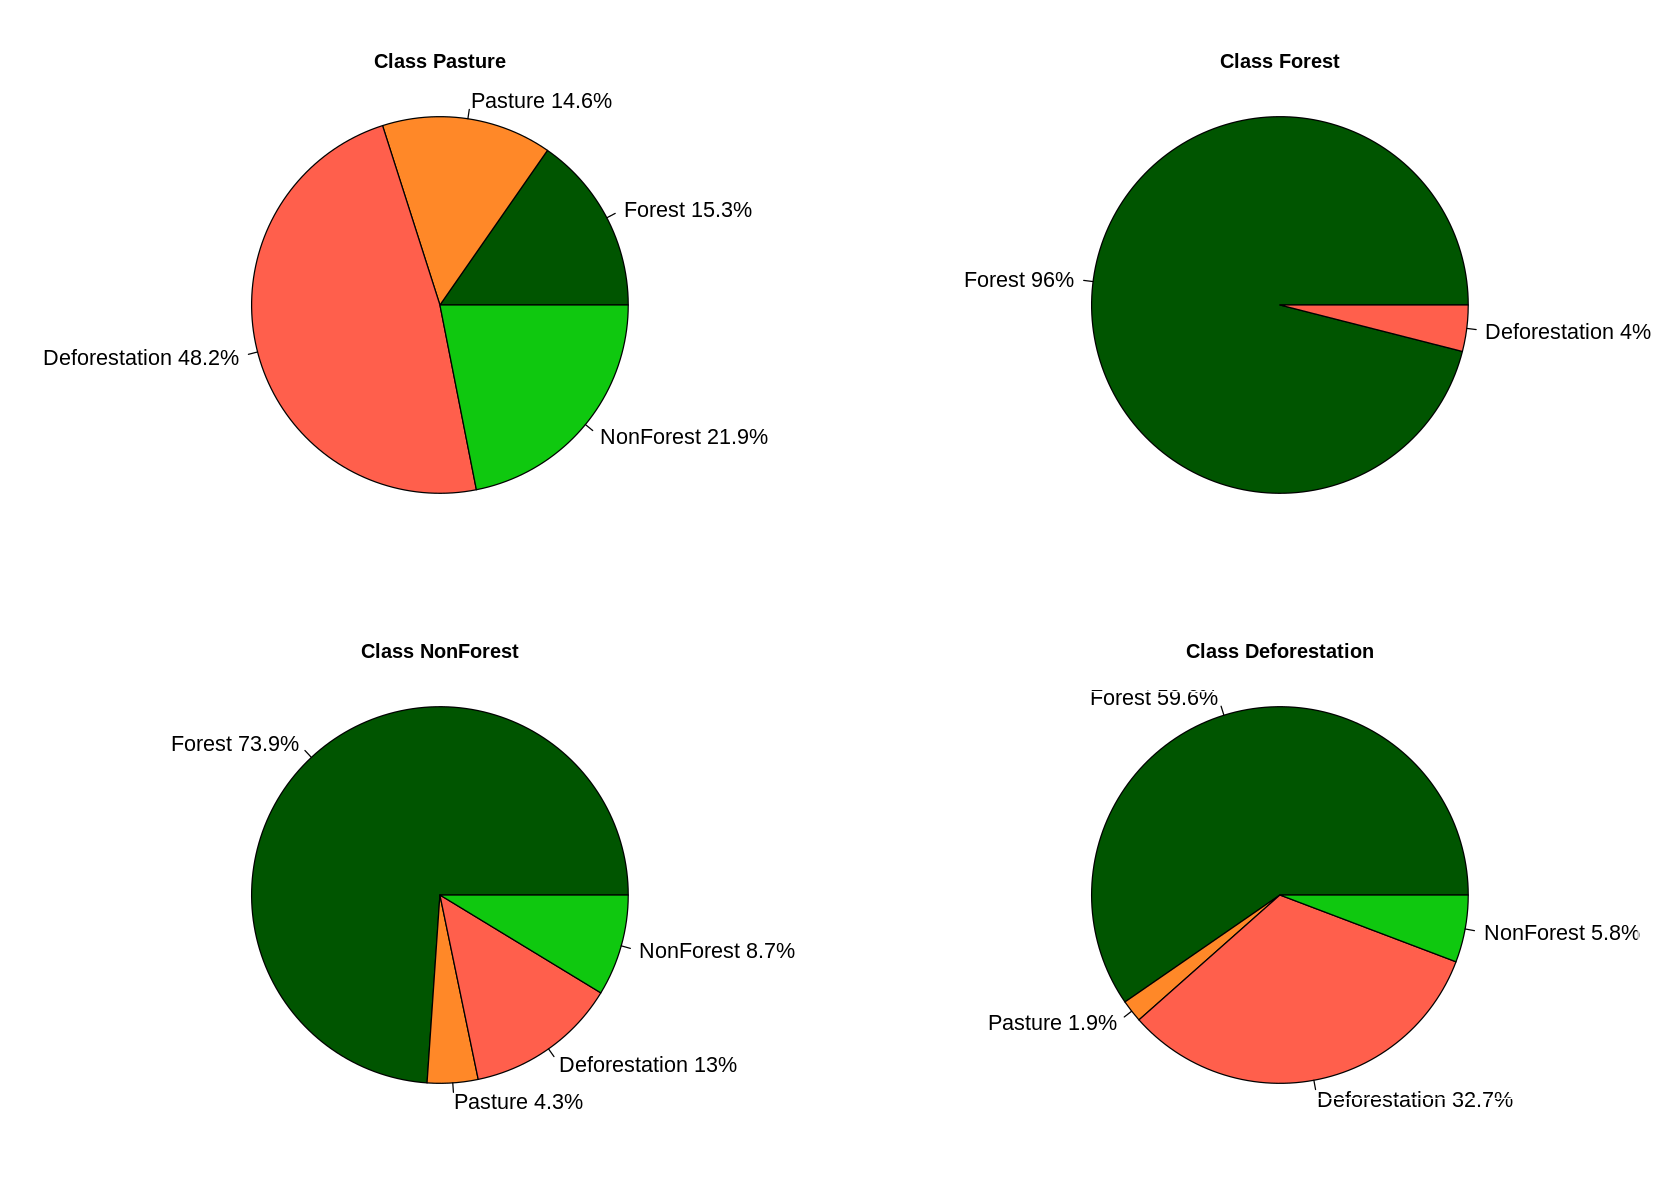

In [60]:
options(repr.plot.width = 14, repr.plot.height = 10)
par(mfrow = c(2,2), oma = c(0,0,1,0), tck = 0)
confusion <- as.data.frame(results$table)
for (i in 1:length(labels_summary$label)) {
    filtered <- dplyr::filter(confusion, Reference == labels_summary[i, ]$label)
    colors <- c()
    for (i in 1:length(filtered$Prediction)) {
        label <- as.character(filtered$Prediction[[i]])
        colors <- append(colors, color.label(label))
    }
    mutation_ <- dplyr::mutate(filtered, percent = Freq/sum(Freq), color = colors)
    mutation_ <- dplyr::filter(mutation_, percent > 0)
    pie(
        mutation_$percent,
        paste(mutation_$Prediction, " ", round((mutation_$percent * 100), 1), "%", sep=""),
        col = mutation_$color,
        main = paste("Class", mutation_$Reference[[1]]),
        cex = 1.3,
        radius = 1
    )
}
box(col = "white")

In [62]:
dt <- sample(nrow(test), 5, replace = FALSE)
dt

[1] 249  82 179 164  42

In [63]:
sample_test_ <- test[dt, ]
dplyr::select(sample_test_, -time_series)

longitude latitude  start_date end_date   label         cube            
1 -63.73442 -10.59127 2018-07-12 2019-07-28 Pasture       LC8_30_16D_STK-1
2 -64.50355 -10.42240 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
3 -64.70629 -10.54799 2018-07-12 2019-07-28 NonForest     LC8_30_16D_STK-1
4 -64.71120 -10.05458 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1
5 -64.43582 -10.91710 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1

In [64]:
prediction <- sample_test_ %>% sits_classify(tCNN_model)
dplyr::select(prediction, -time_series)

longitude latitude  start_date end_date   label         cube            
1 -63.73442 -10.59127 2018-07-12 2019-07-28 Pasture       LC8_30_16D_STK-1
2 -64.50355 -10.42240 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
3 -64.70629 -10.54799 2018-07-12 2019-07-28 NonForest     LC8_30_16D_STK-1
4 -64.71120 -10.05458 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1
5 -64.43582 -10.91710 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1
  predicted                                                                                                                                        
1 17724            , 18105            , Deforestation    , 0.362910687923431, 0.163091942667961, 0.244322806596756, 0.229674533009529              
2 17724             , 18105             , Forest            , 0.081177219748497 , 0.773904919624329 , 0.132745280861855 , 0.0121725564822555       
3 17724            , 18105            , Forest           , 0.226968586444855, 0.318692088127136, 0.297630608081818, 0.156708717346191              
4 17724              , 18105              , Forest             , 0.0790703967213631 , 0.794012010097504  , 0.117599181830883  , 0.00931841135025024
5 17724             , 18105             , Forest            , 0.111330680549145 , 0.735018074512482 , 0.141097992658615 , 0.0125532280653715

In [65]:
toy_case <- list()
for (i in 1:length(prediction$predicted)) {
    probs <- as.data.frame(as.data.frame(prediction[i, ]$predicted)$probs)
    tryCatch(
        expr = {
            toy_case[["True_Label"]] <- append(toy_case[["True_Label"]], prediction[i, ]$label)
            toy_case[["Predicition"]] <- append(toy_case[["Predicition"]], as.data.frame(prediction[i, ]$predicted)$class)
        },
        error = function(e){
            toy_case[["True_Label"]] <- c()
            toy_case[["True_Label"]] <- append(toy_case[["True_Label"]], prediction[i, ]$label)
            
            toy_case[["Prediction"]] <- c()
            toy_case[["Prediction"]] <- append(toy_case[["Prediction"]], as.data.frame(prediction[i, ]$predicted)$class)
        }
    )
    for (label in labels_summary$label) {
        tryCatch(
            expr = {
                toy_case[[label]] <- append(toy_case[[label]], probs[[label]])
            },
            error = function(e){ 
                toy_case[[label]] <- c()
                toy_case[[label]] <- append(toy_case[[label]], probs[[label]])
            }
        )
    }
}
toy_case <- as.data.frame(toy_case)
toy_case

True_Label    Predicition   Pasture     Forest    NonForest Deforestation
1 Pasture       Deforestation 0.229674533 0.1630919 0.2443228 0.36291069   
2 Deforestation Forest        0.012172556 0.7739049 0.1327453 0.08117722   
3 NonForest     Forest        0.156708717 0.3186921 0.2976306 0.22696859   
4 Forest        Forest        0.009318411 0.7940120 0.1175992 0.07907040   
5 Forest        Forest        0.012553228 0.7350181 0.1410980 0.11133068

In [68]:
# Get the labels used in the samples.
reference_labels <- samples_tb %>% 
    dplyr::pull(label) %>% 
    unique() %>%
    sort() %>% 
    magrittr::set_names(seq_len(length(.)))
reference_labels

1               2               3               4 
"Deforestation"        "Forest"     "NonForest"       "Pasture"

In [102]:
# Number of iterations
n_iterations <- 5
# Number of experiments
n_experiments <- 10
# Initial number of labels to be taken from each label.
n_labelled <- 2
# Number of labels to be selected on each iteration.
n_samples <- length(reference_labels) * n_labelled
# Get an initial set of samples
samples_tb <- samples_filtered %>% dplyr::mutate(sample_id = seq_len(nrow(.)))
labelled_samples <- samples_tb %>%
    dplyr::group_by(label) %>% 
    dplyr::sample_n(size = n_labelled) %>%
    dplyr::ungroup()
labelled_samples %>% dplyr::select(-time_series)

longitude latitude  start_date end_date   label         cube            
1 -64.94896 -10.18324 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
2 -64.92765 -10.03792 2018-07-12 2019-07-28 Deforestation LC8_30_16D_STK-1
3 -64.60063 -10.23437 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1
4 -63.97309 -10.94566 2018-07-12 2019-07-28 Forest        LC8_30_16D_STK-1
5 -63.74248 -10.80055 2018-07-12 2019-07-28 NonForest     LC8_30_16D_STK-1
6 -64.66016 -10.54046 2018-07-12 2019-07-28 NonForest     LC8_30_16D_STK-1
7 -65.22917 -10.21245 2018-07-12 2019-07-28 Pasture       LC8_30_16D_STK-1
8 -63.78920 -10.47145 2018-07-12 2019-07-28 Pasture       LC8_30_16D_STK-1
  sample_id
1 846      
2 536      
3 613      
4 372      
5  56      
6 217      
7 533      
8 208

In [70]:
accuracy_tb <- tibble::tibble()

In [71]:
get_acc <- function(conf_mat) {
    overall_accuracy  <- conf_mat$overall["Accuracy"]
    by_class <- conf_mat[["byClass"]]
    f1_score <- by_class[, "F1"]
    prod_acc <- by_class[, "Pos Pred Value"]
    user_acc <- by_class[, "Sensitivity"]
    class_names <- stringr::str_sub(rownames(by_class), 8)
    return(
        tibble::tibble(class = class_names, metric = "f1", accuracy = f1_score) %>%
            dplyr::bind_rows(
                tibble::tibble(class = class_names, metric = "prod_acc", accuracy = prod_acc)
            ) %>%
                dplyr::bind_rows(
                    tibble::tibble(class = class_names, metric = "user_acc", accuracy = user_acc)
                ) %>%
                    dplyr::add_row(class = "overall", metric = "accuracy", accuracy = overall_accuracy)
    )
}

In [72]:
iteration <- function(training_samples, samples_tb, sits_method, reference_labels) {
    
    classification_model  <- sits::sits_train(training_samples, ml_method = arch)
    
    prediction_fct <- samples_tb %>% 
        dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>%
            sits::sits_classify(ml_model = classification_model) %>% 
                dplyr::pull(predicted) %>%
                    purrr::map_chr(magrittr::extract("class")) %>%
                        factor(levels = reference_labels)
    
    reference_fct <- samples_tb %>%
        dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>%
            pull(label) %>% 
                factor(levels = reference_labels)
    
    return(
        caret::confusionMatrix(data = prediction_fct, reference = reference_fct) %>%
            get_acc() %>% 
                dplyr::mutate(n_samples = nrow(training_samples))
    )
}

In [73]:
experiment <- function(x, labelled_samples, n_samples, sits_method){

    #---- Test without active learning ----
    training_samples <- labelled_samples
    for (i in 1:n_iterations) {
    
        new_samples <- samples_tb %>% 
            dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                dplyr::sample_n(size = n_samples)
    
        training_samples <- training_samples %>% 
            dplyr::bind_rows(new_samples) %>% 
                magrittr::set_class(class(sits::cerrado_2classes))
     
        acc_iter <- iteration(training_samples, samples_tb, sits_method, reference_labels) %>% 
            dplyr::mutate(type = "Without AL", iteration = i)
    
        accuracy_tb <- accuracy_tb %>% 
            dplyr::bind_rows(acc_iter)
    }
    
    #---- Test using AL random sampling ----
    training_samples <- labelled_samples %>% 
        magrittr::set_class(class(sits::cerrado_2classes))
    for (i in 1:n_iterations) {
        
        unlabelled_tb <- samples_tb %>% 
            dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                dplyr::mutate(label = NA)
  
        # Use AL random sampling to choose the samples to be sent to the oracle. 
        oracle_samples <- training_samples %>% 
            dplyr::bind_rows(unlabelled_tb) %>% 
                al_random_sampling(sits_method = sits_method, multicores = 1) %>% 
                    dplyr::filter(sample_id %in% unlabelled_tb$sample_id) %>% 
                        dplyr::arrange(dplyr::desc(entropy)) %>% 
                            dplyr::slice_head(n = n_samples) %>% 
                                dplyr::select(-entropy, -least_conf, -margin_conf, -ratio_conf, -new_label)
    
        # Get the true labels from the oracle
        oracle_samples <- oracle_samples %>% 
            dplyr::left_join(y = samples_tb %>% 
                dplyr::filter(!(sample_id %in% training_samples$sample_id)) %>% 
                    dplyr::select(true_label = label, sample_id), by = "sample_id") %>% 
                        dplyr::mutate(label = true_label) %>%
                              dplyr::select(-true_label)
                    
        # Add the oracle samples to the training set.
        training_samples <- training_samples %>% 
            dplyr::bind_rows(oracle_samples) %>% 
                magrittr::set_class(class(sits::cerrado_2classes))
    
        # Do the classification and estimate the accuracy.
        acc_iter <- iteration(training_samples, samples_tb, sits_method, reference_labels) %>% 
            dplyr::mutate(type = "AL Random Sampling", iteration = i)
    
        accuracy_tb <- accuracy_tb %>% 
            dplyr::bind_rows(acc_iter)
    }
    
    return(
        accuracy_tb %>% 
            dplyr::mutate(experiment = x)
    )
}

In [103]:
accuracy_lst <- parallel::mclapply(
    1:n_experiments,
    experiment, 
    labelled_samples = labelled_samples, 
    n_samples = n_samples,
    sits_method = arch,
    mc.cores = 1
)

In [105]:
save_file.tb(accuracy_lst, "data/output/accuracy_lst", "rda")

Warning message:
“Removed 129 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 129 rows containing non-finite values (stat_boxplot).”


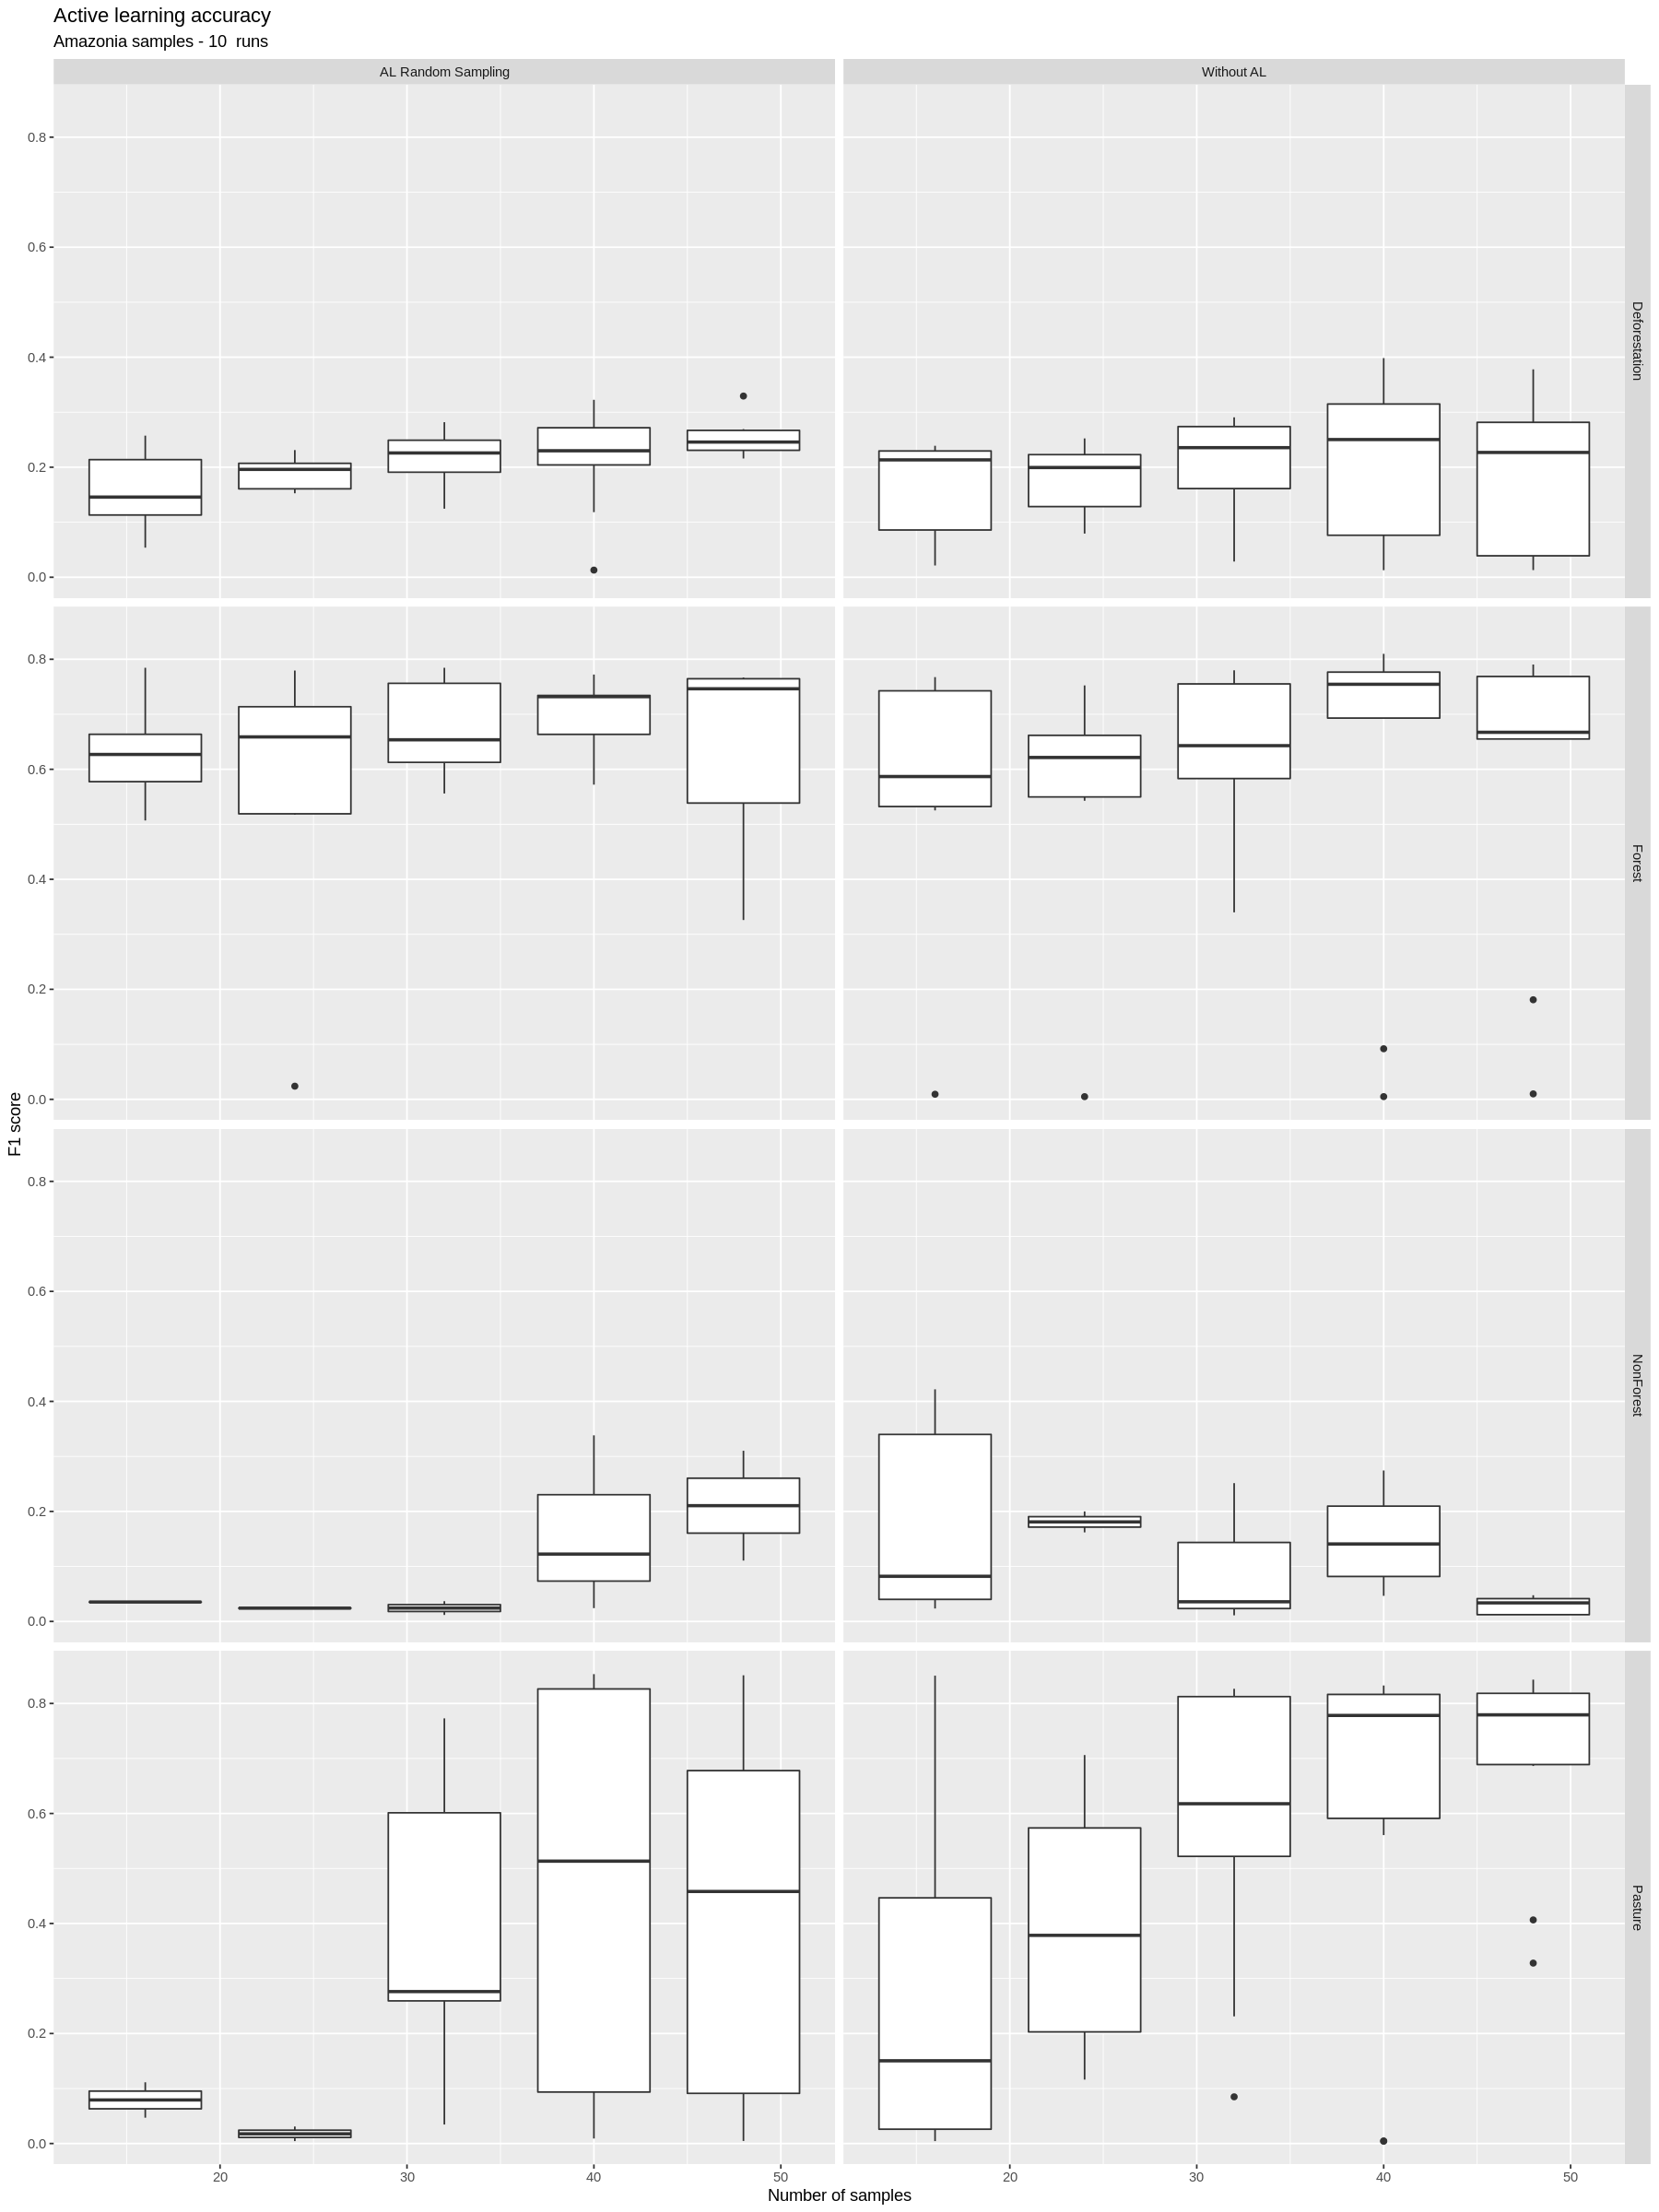

In [106]:
options(repr.plot.width = 15, repr.plot.height = 20)
accuracy_lst %>% 
  dplyr::bind_rows() %>% 
  dplyr::filter(metric == "f1") %>%
  ggplot2::ggplot() + 
  ggplot2::geom_boxplot(ggplot2::aes(x = n_samples,
                                     y = accuracy,
                                     group = n_samples)) +
  ggplot2::facet_grid(cols = dplyr::vars(type),
                      rows = dplyr::vars(class)) +
  ggplot2::labs(title = "Active learning accuracy",
                subtitle = paste("Amazonia samples",
                                 paste(n_experiments, " runs"),
                                 sep = " - ")) +
  ggplot2::xlab("Number of samples") + 
  ggplot2::ylab("F1 score")

ggplot2::ggsave(filename = "./comparison_deforestation.png",
                width = 297,
                height = 210,
                units = "mm")